In [1]:
# tutorials page
# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Geometric_deep_learning

# website
# https://uvadl2c.github.io/lectures-2022.html


### 0. Installing and importing

In [7]:
# Standard libraries
import os
import numpy as np
import math
from PIL import Image
from functools import partial


# Import for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning 
                            #installed by defalult. Hence, we install if nessesary
        !pip install pytorch-lightning==1.5.1
        import pytorch_lightning as pl
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [8]:
# Path to the folder where the datasets are be downloaded ( e. g. MNIST)
DATASET_PATH = "./data"

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("mps") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
import urllib.request
from urllib.error import HTTPError

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/DL2/GDL/"

# Files to download
files = ['paprika.tiff']

# For each file, check whether it already exists. If not, try downloading it
for file_name in files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder,")
            print("or contact the author with the full output including the following error:\n", e)

## 1. Implementing group in python

### 1.0 Base class

In [10]:
class GroupBase(torch.nn.Module):
    
    def __init__(self, dimension, identity):
        """Implementing a group
        
        @param dimension: Dimensionality of the group (number of dimensions in the basis of the algebra).
        @param identity: Identity element of the group
        
        """
        super().__init__()
        self.dimension = dimension
        self.register_buffer('identity', torch.Tensor(identity))
        
        
    def elements(self):
        """Obtain a tensor containing all group elements in this group
        
        """
        
        raise NotImplementedError()
        
    def product(self, h, h_prime):
        """ Defines group product on two group elements.
        
        @param h: group element 1 
        @param h_prime: group element 2
        
        """
        
        raise NotImplementedError()
        
    def inverse(self, h):
        
        """ Defines inverse for group element 
        
        @ param h: A group element from subgroup H
        
        """
        
        raise NotADirectoryError()
        
    
    def left_action_on_R2(self, h, x):
        """ Group action of an element from the subgroup H on a vector in R2.

        @param h: A group element from subgroup H.
        @param x: Vectors in R2.
        """
        
        raise NotImplementedError()
        
    
    
    def determinant(self, h):
        """Calculate the determinant of the representation of a group element h.
        
        
        @param h: group element
        """
        
        raise NotImplementedError()
        
    def normalize_group_parametrization(self, h):
        """ Map the group elements to an interval [-1, 1]. We use this to create
        a standardized input for obtaining weights over the group
        
        
        @param h: group element
        """
        
        raise NotImplementedError()

### 1.1 C4 implementation

In [23]:
class CyclicGroup(GroupBase):
    
    def __init__(self, order):
        """Implementing a group
        
        @param dimension: Dimensionality of the group (number of dimensions in the basis of the algebra).
        @param identity: Identity element of the group
        
        """
        super().__init__(dimension = 1, identity = [0.])
        
        assert order > 1
        
        self.order = torch.tensor(order)
        
        
    def elements(self):
        """Obtain a tensor containing all group elements in this group.
        
        
        @ return elements: Tensor containing group elements of shape [self.order]
        """
        
        return torch.linspace(start = 0, 
                              end = 2 * np.pi * float(self.order - 1) / float(self.order),
                              steps = self.order,
                              device = self.identity.device
        )
    
        
    def product(self, h, h_prime):
        """ Defines group product on two group elements of the cyclic group C4.
        
        @param h: group element 1 
        @param h_prime: group element 2
        
        @ returns product: Tensor containing h \cdot h_prime with \cdot the group action
        """
        
        product = (h + h_prime) % (2 * np.pi)
        
        return product
        
        
    def inverse(self, h):
        
        """ Defines inverse for group element of the cyclic group C4
        
        @ param h: A group element 
        
        @ returns inverse: Tensor containing h^{-1}
        """
        
        inverse = (-h) % (2 * np.pi)
        
        return inverse
        
    
    def left_action_on_R2(self, h, x):
        """ Group action of an element from the subgroup H on a vector in R2.

        @param h: A group element from subgroup H.
        @param x: Vectors in R2.
        
        @ returns transformed_x: Tensor containing \rho(h) x.
        """
        
        # Transform the vector x with h, recall that we are working with a left-regular representation,
        # meaning we transform vectors in R^2 through left-matrix multiplication
        transformed_x = torch.tensordot(self.matrix_representation(h), x, dims = 1)
        return transformed_x
    
    def matrix_representation(self, h):
        """ Obtain a matrix representation in R^2 for an element h.
        
        @ param h: A group element.
        
        @returns representation: Tensor containing matrix representation of h, shape [2, 2]
        """
    
        representation = torch.tensor([[np.cos(h), -np.sin(h)], [np.sin(h), np.cos(h)]])
        
        return representation
    
    
        
    def normalize_group_elements(self, h):
        """ Map the group elements to an interval [-1, 1]. We use this to create
        a standardized input for obtaining weights over the group
        
        
        @param h: group element
        
        @return normalized_h: Tensor containing normalized value corresponding to element h
        """
        largest_elem = 2 * np.pi * (self.order - 1) / self.order
        normalized_h = (2*h / largest_elem) - 1
        
        raise normalized_h

### 1.2 tests

In [26]:
# Some tests to verify our implementation
c4 = CyclicGroup(order = 4)

e, g1, g2, g3 = c4.elements()

assert c4.product(e, g1) == g1 and c4.product(g1, g2) == g3
assert c4.product(g1, c4.inverse(g1)) == e


# torch allclose determines if elements in the matrix are close to each other
assert torch.allclose(c4.matrix_representation(e), torch.eye(2))
assert torch.allclose(c4.matrix_representation(g2), torch.tensor([[-1., 0.], [0., -1.]]), atol = 1e-6)

assert torch.allclose(c4.left_action_on_R2(g1, torch.tensor([0., 1.])), torch.tensor([-1., 0]), atol = 1e-7)

### 1.3 visualization

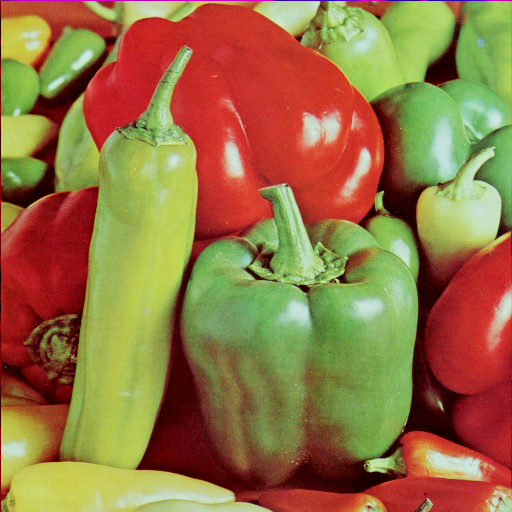

In [27]:
# Load image from disk.
img = Image.open(os.path.join(CHECKPOINT_PATH, 'paprika.tiff'))

# Convert to torch tensor.
img_tensor = transforms.ToTensor()(img)
img

In [37]:
def bilinear_interpolation(signal, grid):
    """ Obtain signal values for a set of gridpoints through bilinear interpolation
    
    @param signal: Tensor containing pixel values [C, H, W] or [N, C, H, W]
    @param grid: Tensor containing coordinate values [2, Hf, Wf] or [2, N, Hf, Wf]
    
    @return signal_out: Tensor containing pixel values [C, Hf, Wf] or [N, C, Hf, Wf] 
    """
    # If signal or grid is a 3D array, add a dimension to support grid_sample.
    # This means adding batch dimension
    if len(signal.shape) == 3:
        signal = signal.unsqueeze(0)
    if len(grid.shape) == 3:
        grid = grid.unsqueeze(1)
        
    # Grid sample expects [N, H, W, 2] instead of [2, N, H, W]
    grid = grid.permute(1, 2, 3, 0)
    
    # Grid sample expects YX instead of XY
    grid = torch.roll(grid, shifts = 1, dims = -1)
    
    signal_out = torch.nn.functional.grid_sample(signal, 
                                                 grid, 
                                                 padding_mode='zeros',
                                                 align_corners = True,
                                                 mode = 'bilinear',
                                                )
    
    
    return signal_out
    
def trilinear_interpolation(signal, grid):
    """ Obtain signal values for a set of gridpoints through trilinear interpolation
    
    @param signal: Tensor containing pixel values [C, D, H, W] or [N, C, D, H, W]
    @param grid: Tensor containing coordinate values [2, Df, Hf, Wf] or [2, N, Df, Hf, Wf]
    
    @return signal_out: Tensor containing pixel values [C, Df, Hf, Wf] or [N, C, Df, Hf, Wf] 
    """
    # If signal or grid is a 3D array, add a dimension to support grid_sample.
    # This means adding batch dimension
    if len(signal.shape) == 4:
        signal = signal.unsqueeze(0)
    if len(grid.shape) == 4:
        grid = grid.unsqueeze(1)
        
    # Grid sample expects [N, H, W, 2] instead of [2, N, H, W]
    grid = grid.permute(1, 2, 3, 4, 0)
    
    # Grid sample expects YX instead of XY
    grid = torch.roll(grid, shifts = 1, dims = -1)
    
    signal_out = torch.nn.functional.grid_sample(signal, 
                                                 grid, 
                                                 padding_mode='zeros',
                                                 align_corners = True,
                                                 mode = 'bilinear', # actually trilinear in this case ...
                                                )
    
    
    return signal_out

In [38]:
# This creates a grid of the pixel location in our image of [2, 512, 512] since
# our image is 2 dimensional and has a width and height of 512 pixels.
img_grid = torch.stack(torch.meshgrid(
    torch.linspace(-1, 1, img_tensor.shape[-2]),
    torch.linspace(-1, 1, img_tensor.shape[-1]),
    indexing='ij'
))


# Let's create the group of 90 degree clockwise rotations
c4 = CyclicGroup(order=4)
e, g1, g2, _ = c4.elements()

# Create a counterclockwise rotation of 270 degrees using only e, g1 and g2
g3 = c4.product(g1, g2)

assert g3 == c4.elements()[-1]

In [39]:
# Transform the image grid we just created with the matrix representation of
# this group element.
transformed_img_grid = c4.left_action_on_R2(c4.inverse(g3), img_grid)

# Sample the image on the transformed grid points
transformed_img = bilinear_interpolation(img_tensor, transformed_img_grid)[0]

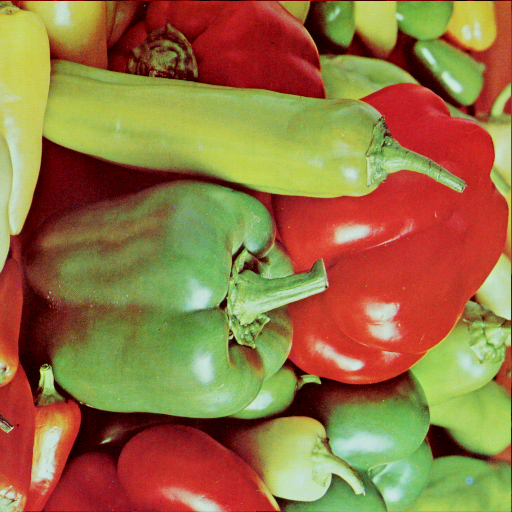

In [40]:
# If we turn this back to a PIL image we can see the result of our transformation!
transforms.ToPILImage()(transformed_img)